Based heavily on Dakeya's notebook.

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [2]:
newdata = Table.read('FinalData.csv', format = 'ascii.csv')
Ccolor = (newdata['F275W_1']-newdata['F366W_1']) - (newdata['F366W_1']-newdata['F438W_1'])

In [3]:
oxok = ~newdata['[O/Fe]'].mask
np.sum(oxok), len(oxok)

(25, 36)

C vs. [O/Fe]

Text(0, 0.5, '[O/Fe]')

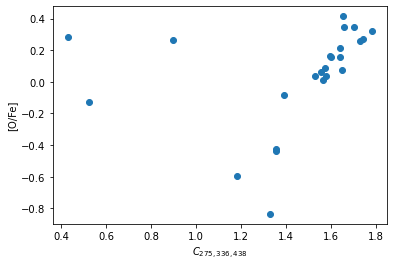

In [4]:
plt.scatter(Ccolor[oxok], newdata['[O/Fe]'][oxok])
plt.xlabel('$C_{275,336,438}$')
plt.ylabel('[O/Fe]')

Marino 19 has a maximum range of 0.5 mag in $\Delta_C$ for this cluster. That's not the same as $C$, but it makes me extremely dubious about those points with $C<1$. Also, we have 36 matches and Marino only reports 31 matches. So I am going to assume those are bad matches.

In [5]:
oxok *= (Ccolor > 1)
np.sum(oxok)

22

First question: how good is this on its own?

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [7]:
Creg = LinearRegression()
x = np.array(Ccolor)
y = np.array(newdata['[O/Fe]'])
Creg.fit(x[oxok,np.newaxis], y[oxok])

LinearRegression()

Text(0, 0.5, '[O/Fe]')

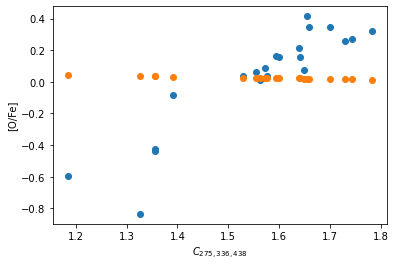

In [8]:
Cax = np.arange(1,2,0.1)

plt.scatter(Ccolor[oxok], newdata['[O/Fe]'][oxok])
plt.scatter(Ccolor[oxok], Creg.predict(Ccolor[oxok].reshape(-1,1)))
#plt.plot(Cax, Creg.predict(Cax[:,np.newaxis]))
plt.xlabel('$C_{275,336,438}$')
plt.ylabel('[O/Fe]')

In [9]:
Creg.coef_, Creg.intercept_

(array([-0.04689765]), 0.09814253989678082)

I'm not sure why that's not working, but let's try linear regression with all 5 magnitudes.

In [10]:
x = (np.stack(( np.array(newdata['F275W_1']-newdata['F814W_1']), np.array(newdata['F814W_1']), np.array(newdata['F366W_1']-newdata['F814W_1']), np.array(newdata['F438W_1']-newdata['F814W_1']), np.array(newdata['F606W_1']-newdata['F814W_1'])), axis = 1))
y = np.array(newdata['[O/Fe]'])

In [11]:
linreg = LinearRegression()
linreg.fit(x[oxok,:], y[oxok])

LinearRegression()

Text(0, 0.5, 'Linear Regression [O/Fe]')

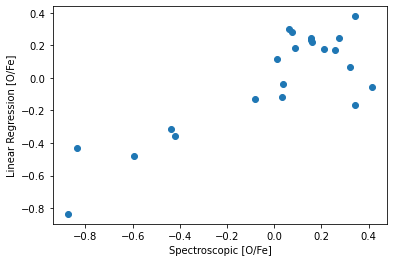

In [12]:
plt.scatter(y[oxok], linreg.predict(x[oxok,:]))
plt.xlabel('Spectroscopic [O/Fe]')
plt.ylabel('Linear Regression [O/Fe]')

In [13]:
# Measure the scatter around predicted value
linreg_disp = np.std( y[oxok] - linreg.predict(x[oxok,:]) )
print(linreg_disp)

0.20505316078544994


Extract test vs. train sets. Make sure test set spans the range of values.

In [14]:
y[oxok]

array([-0.834,  0.063,  0.344,  0.212,  0.012, -0.595,  0.037,  0.034,
        0.156, -0.439,  0.086, -0.422, -0.875,  0.415,  0.259,  0.32 ,
       -0.082,  0.156,  0.075,  0.162,  0.273,  0.344])

In [15]:
np.where(oxok)[0]

array([ 4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 25,
       28, 29, 30, 31, 33])

In [16]:
testset = [13,5,17,31]
test = np.zeros_like(oxok, dtype=bool)
test[testset] = True
y[test]

array([ 0.063,  0.034, -0.422,  0.273])

In [17]:
train = oxok.copy()
train[testset] = False
y[train]

array([-0.834,  0.344,  0.212,  0.012, -0.595,  0.037,  0.156, -0.439,
        0.086, -0.875,  0.415,  0.259,  0.32 , -0.082,  0.156,  0.075,
        0.162,  0.344])

Try the linear regression again, separating test vs. train.

In [18]:
linreg = LinearRegression()
linreg.fit(x[train,:], y[train])

LinearRegression()

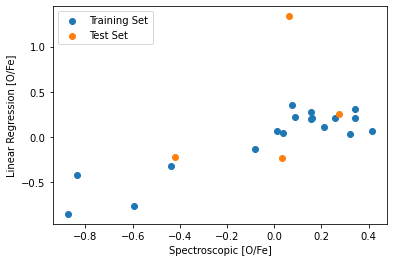

In [19]:
plt.scatter(y[train], linreg.predict(x[train,:]), label='Training Set')
plt.scatter(y[test], linreg.predict(x[test,:]), label='Test Set')
plt.xlabel('Spectroscopic [O/Fe]')
plt.ylabel('Linear Regression [O/Fe]')
plt.legend()

Looks like there's some overfitting.

Now let's go to polynomial.

In [20]:
degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(x[train,:], y[train])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

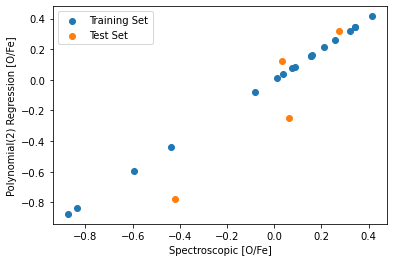

In [21]:
plt.scatter(y[train], polyreg.predict(x[train,:]), label='Training Set')
plt.scatter(y[test], polyreg.predict(x[test,:]), label='Test Set')
plt.xlabel('Spectroscopic [O/Fe]')
plt.ylabel('Polynomial(2) Regression [O/Fe]')
plt.legend()

In [22]:
# Measure the scatter around predicted value
polyreg_disp = np.std( y[oxok] - polyreg.predict(x[oxok,:]) )
print(polyreg_disp)

0.09996702101336269


Dispersion is worse because of massive overfitting.

Let's add in Ridge.

In [23]:
ridgepolyreg = make_pipeline(PolynomialFeatures(2), Ridge(alpha=0.0001))
ridgepolyreg.fit(x[train,:], y[train])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(alpha=0.0001))])

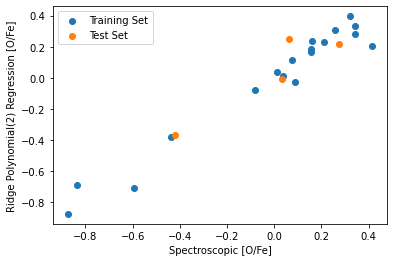

In [24]:
plt.scatter(y[train], ridgepolyreg.predict(x[train,:]), label='Training Set')
plt.scatter(y[test], ridgepolyreg.predict(x[test,:]), label='Test Set')
plt.xlabel('Spectroscopic [O/Fe]')
plt.ylabel('Ridge Polynomial(2) Regression [O/Fe]')
plt.legend()

In [25]:
# Measure the scatter around predicted value
ridgepolyreg_disp = np.std( y[oxok] - ridgepolyreg.predict(x[oxok,:]) )
print(ridgepolyreg_disp)

0.08542973841542699


Dispersion is about the same, but it's about equal for both the training and test set, so it's not because of overfitting. This looks good enough for the proposal!

In [26]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14, lw=2)

In [27]:
ridgepoly_sigtrain = np.std(ridgepolyreg.predict(x[train,:])-y[train])
ridgepoly_sigtest = np.std(ridgepolyreg.predict(x[test,:])-y[test])

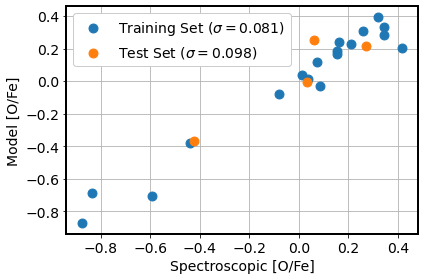

In [28]:
plt.scatter(y[train], ridgepolyreg.predict(x[train,:]), label=f'Training Set ($\sigma={ridgepoly_sigtrain:.3f}$)', s=80)
plt.scatter(y[test], ridgepolyreg.predict(x[test,:]), label=f'Test Set ($\sigma={ridgepoly_sigtest:.3f}$)', s=80)
plt.xlabel('Spectroscopic [O/Fe]')
plt.ylabel('Model [O/Fe]')
plt.grid('on')
#plt.title('NGC 2808')
plt.legend(framealpha=1., fontsize=14)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.savefig('ngc2808-ridgepoly.pdf')

Do it for all of RGB.

In [29]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [30]:
phot = Table.read('hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc2808_multi_v1_catalog-meth1.txt',
                  format='ascii')
phot['col1'].name='x'
phot['col2'].name='y'
phot['col3'].name='F275W'
phot['col9'].name='F336W'
phot['col15'].name='F438W'
phot['col21'].name='F606W'
phot['col27'].name='F814W'
phot['col33'].name='membership'

In [31]:
goodphot = (phot['F275W']!=-99.9999) * (phot['F336W']!=-99.9999) * (phot['F438W']!=-99.9999) * \
    (phot['F606W']!=-99.9999) * (phot['F814W']!=-99.9999)

(18.0, 10.0)

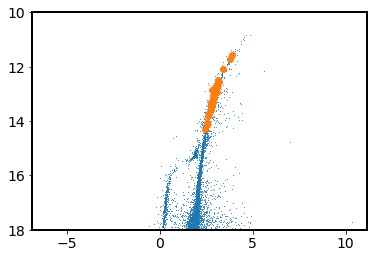

In [32]:
plt.scatter((phot['F438W']-phot['F814W'])[goodphot], phot['F814W'][goodphot], s=1, lw=0)
plt.scatter(newdata['F438W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

In [33]:
np.min(newdata['F814W_1']), np.max(newdata['F814W_1'])

(11.5788, 14.2848)

In [34]:
rgb_p = (phot['F814W'] > 11.5) * (phot['F814W'] < 14.3)
rgb = goodphot * rgb_p

(18.0, 10.0)

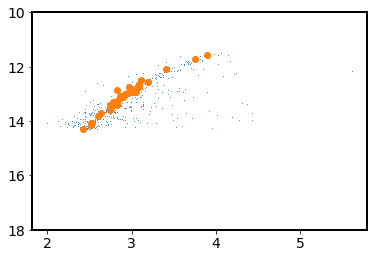

In [35]:
plt.scatter((phot['F438W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F438W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

(18.0, 10.0)

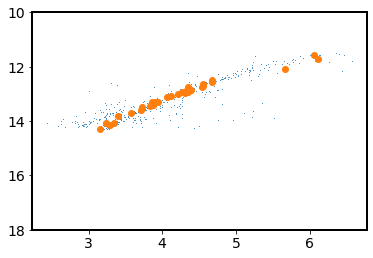

In [36]:
plt.scatter((phot['F336W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F366W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

(18.0, 10.0)

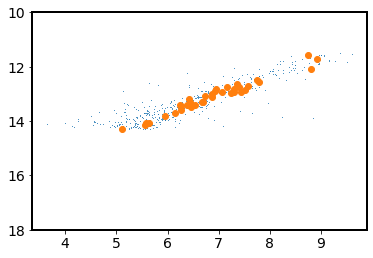

In [37]:
plt.scatter((phot['F275W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F275W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

Looks pretty linear there.

In [38]:
rgbreg = LinearRegression()
rgbreg.fit((newdata['F275W_1']-newdata['F814W_1']).reshape(-1,1), newdata['F814W_1'])

LinearRegression()

In [39]:
rgbreg.intercept_, rgbreg.coef_

(17.818190516659058, array([-0.6848541]))

In [40]:
rgbreg_std = np.std(newdata['F814W_1'] - rgbreg.predict((newdata['F275W_1']-newdata['F814W_1']).reshape(-1,1)))
rgbreg_std

0.12935753458764992

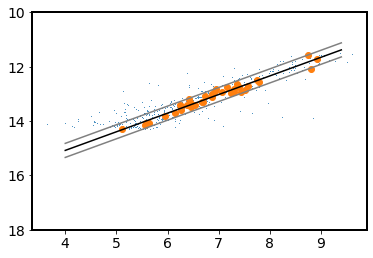

In [41]:
plt.scatter((phot['F275W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F275W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)
cax = np.arange(4,9.5,0.1)
plt.plot(cax, rgbreg.predict(cax.reshape(-1,1)), color='black')
plt.plot(cax, rgbreg.predict(cax.reshape(-1,1)) + 2*rgbreg_std, color='gray')
plt.plot(cax, rgbreg.predict(cax.reshape(-1,1)) - 2*rgbreg_std, color='gray')

In [42]:
rgb_p = np.abs(phot['F814W'] - rgbreg.predict((phot['F275W']-phot['F814W']).reshape(-1,1))) <= 2*rgbreg_std
rgb = rgb * rgb_p

(18.0, 10.0)

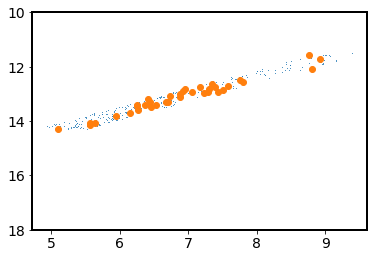

In [43]:
plt.scatter((phot['F275W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F275W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

(18.0, 10.0)

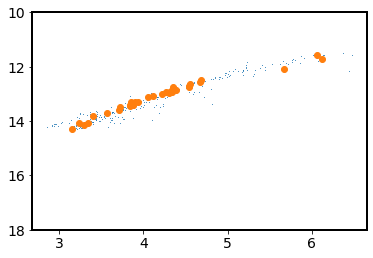

In [44]:
plt.scatter((phot['F336W']-phot['F814W'])[rgb], phot['F814W'][rgb], s=1, lw=0)
plt.scatter(newdata['F366W_1']-newdata['F814W_1'], newdata['F814W_1'])
plt.ylim(18,10)

Looks good, let's see what that gives us!

In [45]:
rgb_x = (np.stack(( np.array(phot['F275W']-phot['F814W']), np.array(phot['F814W']), np.array(phot['F336W']-phot['F814W']), np.array(phot['F438W']-phot['F814W']), np.array(phot['F606W']-phot['F814W'])), axis = 1))[rgb]

In [46]:
rgb_x.shape

(298, 5)

In [47]:
rgb_OFe = ridgepolyreg.predict(rgb_x)

In [48]:
print(rgb_OFe.min(), rgb_OFe.max())
print(np.min(newdata['[O/Fe]'][oxok]), np.max(newdata['[O/Fe]'][oxok]))

-5.298511730643182 45.58464020474882
-0.875 0.415


Don't trust anything that's outside original bounds.

In [49]:
goodpred = (rgb_OFe >= np.min(newdata['[O/Fe]'][oxok])) * \
    (rgb_OFe <= np.max(newdata['[O/Fe]']))

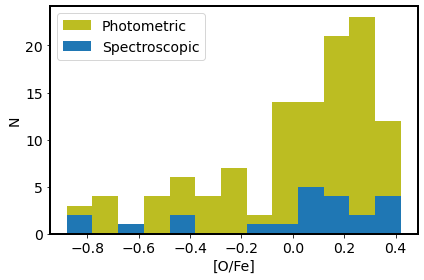

In [50]:
binedges = np.arange(-0.88,0.52,0.1)
plt.hist(rgb_OFe[goodpred], bins=binedges, label='Photometric', color='C8')
plt.hist(newdata['[O/Fe]'][oxok], bins=binedges, label='Spectroscopic', color='C0')
plt.xlabel('[O/Fe]')
plt.ylabel('N')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('ngc2808-phot-oxdist.pdf')

In [51]:
np.sum(goodpred), np.sum(oxok)

(115, 22)

In [52]:
115./22

5.2272727272727275

In [53]:
centerpt = (5000,5000)
radius_px = np.sqrt( (phot['x'][rgb]-centerpt[0])**2 + (phot['y'][rgb]-centerpt[1])**2 )
radius_arcsec = radius_px * 0.04

Text(0, 0.5, '[O/Fe]')

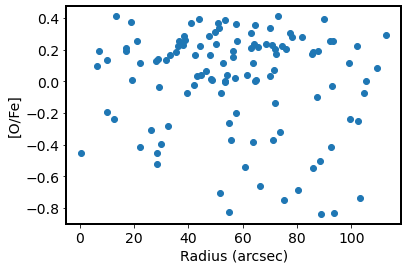

In [57]:
plt.scatter(radius_arcsec[goodpred], rgb_OFe[goodpred])
plt.xlabel('Radius (arcsec)')
plt.ylabel('[O/Fe]')

In [58]:
from scipy.stats import binned_statistic

In [59]:
mean_ofe = binned_statistic(radius_arcsec[goodpred], rgb_OFe[goodpred], statistic='mean')
std_ofe = binned_statistic(radius_arcsec[goodpred], rgb_OFe[goodpred], statistic='std')

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

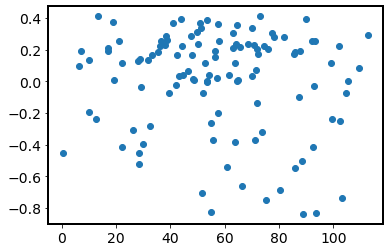

In [62]:
ec = 'C1'
plt.scatter(radius_arcsec[goodpred], rgb_OFe[goodpred])
for i in range(len(mean_ofe.statistic)):
    plt.plot([mean_ofe.bin_edges[i],mean_ofe.bin_edges[i+1]], mean_ofe.statistic[i]*[1,1], color=ec)
    plt.plot(0.5*(mean_ofe.bin_edges[i]+mean_ofe.bin_edges[i+1])*[1,1], 
             [mean_ofe.statistic[i]-std_ofe.statistic[i], mean_ofe.statistic[i]+std_ofe.statistic[i]], color=ec)
plt.xlabel('Radius (arcsec)')
plt.ylabel('[O/Fe]')

In [ ]:
mean_ofe